In [1]:

from src.data.dataset_reader import DatasetReader
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
data_folder = Path("../data/raw").resolve()

amazon = DatasetReader(data_folder).get_data_csv('Amazon_Sale_Report.csv')



In [2]:
from src.data.feature_engineering import FeatureEngineeringProcess
fep = FeatureEngineeringProcess()


In [3]:
# Create a new feature called sales that is the  the count of "Amount" grouped by "SKU" in the amazon dataset
#amazon['sales'] = amazon.groupby('SKU')['Amount'].transform('count')
#amazon.drop(columns=[ 'Order ID', 'ASIN', 'Unnamed: 22', 'index'], inplace=True
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon['ship-postal-code'] = amazon['ship-postal-code'].astype('object')
amazon.rename(columns={'Amount': 'price'}, inplace=True)
amazon_beta =  amazon[['Order ID','Date', 'SKU', 'Qty', 'price']]

In [4]:
from src.data.eda import Eda
eda = Eda(    
)

eda.missing_values_table(amazon_beta)

The selected dataframe has 5 columns and 1 columns with missing values.


,Missing Values,% of Total Values
price,7795,6.0


In [5]:
# impute price missing values with the mean
amazon_beta['price'].fillna(amazon_beta['price'].mean(), inplace=True)

In [ ]:
#toy = amazon_beta.query('SKU == "SET389-KR-NP-S"').sort_values(by='Date', ascending=True)
#toy['sales'] = toy.groupby(['SKU', 'Date', 'price'])['Order ID'].transform('count')

In [6]:

# Create a column called "sales" that is the count of the "Order ID" grouped by "SKU" and "Date" and price in the amazon_beta dataset
amazon_beta['sales'] = amazon_beta.groupby(['SKU', 'Date', 'price'])['Order ID'].transform('count')
amazon_beta.sort_values(by=['SKU', 'Date'], ascending=True, inplace=True)

In [7]:
amazon_beta_fe1 = fep.price_sales_correlation_features_updated(amazon_beta, 10, [(-5.0, 1.0), (-3.0, 1.0), (-2.0, 1.0), (1.0, 1.0), (-1.0, 0.5), (-1.0, 0.33)])


In [8]:

#amazon_beta_fe1.query('SKU == "SET389-KR-NP-S"').sort_values(by='Date', ascending=True).head()
# calculate average number of Date in each SKU
#amazon_beta_fe1.groupby('SKU')['Date'].nunique().mean()
# add a column called "days" that is the count of "Date" of each SKU
#amazon_beta_fe1['days'] = amazon_beta_fe1.groupby('SKU')['Date'].transform('nunique')
#amazon_beta_fe1.drop(columns=['days'], inplace=True)
eda.missing_values_table(amazon_beta_fe1)


The selected dataframe has 12 columns and 6 columns with missing values.


,Missing Values,% of Total Values
f_corr_-5.0_1.0,57436,44.5
f_corr_-3.0_1.0,57436,44.5
f_corr_-2.0_1.0,57436,44.5
f_corr_-1.0_0.5,57436,44.5
f_corr_-1.0_0.33,57436,44.5
f_corr_1.0_1.0,43722,33.9


In [9]:
amazon_beta_fe2 = fep.normalize_features(amazon_beta_fe1, [5, 10, 15], 28)

In [10]:
# check for infs
import numpy as np
amazon_beta_fe2[amazon_beta_fe2 == np.inf].count()

Order ID                            0
Date                                0
SKU                                 0
Qty                                 0
price                               0
sales                               0
f_corr_-5.0_1.0                     0
f_corr_-3.0_1.0                     0
f_corr_-2.0_1.0                     0
f_corr_1.0_1.0                      0
f_corr_-1.0_0.5                     0
f_corr_-1.0_0.33                    0
normalized_log_avg_price_5_days     0
normalized_log_avg_sales_5_days     0
normalized_std_price_5_days         0
normalized_std_sales_5_days         0
normalized_log_avg_price_10_days    0
normalized_log_avg_sales_10_days    0
normalized_std_price_10_days        0
normalized_std_sales_10_days        0
normalized_log_avg_price_15_days    0
normalized_log_avg_sales_15_days    0
normalized_std_price_15_days        0
normalized_std_sales_15_days        0
dtype: int64

In [30]:
amazon_beta_fe3, insuficient_data = fep.filter_stability_periods(amazon_beta_fe2, 7, 0.04)

In [31]:

eda.missing_values_table(amazon_beta_fe3)

The selected dataframe has 24 columns and 18 columns with missing values.


,Missing Values,% of Total Values
f_corr_-5.0_1.0,48951,67.4
f_corr_-2.0_1.0,48951,67.4
f_corr_-1.0_0.5,48951,67.4
f_corr_-1.0_0.33,48951,67.4
f_corr_-3.0_1.0,48951,67.4
normalized_log_avg_sales_15_days,46702,64.3
normalized_log_avg_price_15_days,46702,64.3
normalized_log_avg_price_10_days,44390,61.1
normalized_log_avg_sales_10_days,44390,61.1
normalized_std_price_15_days,43781,60.3


Features to drop: ['f_corr_-3.0_1.0', 'f_corr_-2.0_1.0', 'f_corr_-1.0_0.5', 'f_corr_-1.0_0.33']


<Axes: >

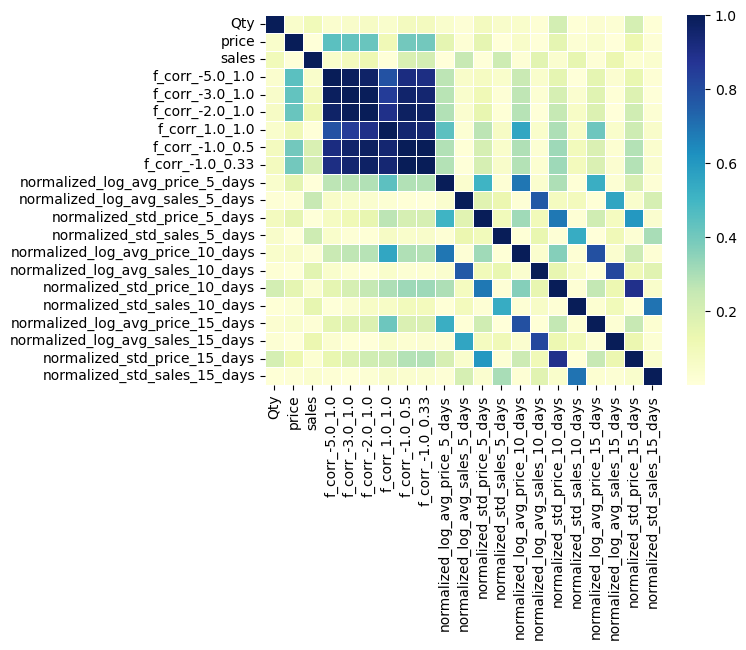

In [32]:
import seaborn as sns
# Create a correlation matrix to check for multicollinearity
corr_matrix = amazon_beta_fe3.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Features to drop: {to_drop}")
# Plot the heatmap, make the plot readeble and annotate the values

sns.heatmap(corr_matrix, annot=False, cmap="YlGnBu", fmt='.2f', linewidths=.5, annot_kws={"size": 7})

# Drop features
#amazon_beta_fe3.drop(to_drop, axis=1, inplace=True)


In [33]:
amazon_beta_train= fep.datetime_transform(amazon_beta_fe3, 'Date',['day_of_the_year'])

In [34]:
eda.missing_values_table(amazon_beta_train)

The selected dataframe has 25 columns and 18 columns with missing values.


,Missing Values,% of Total Values
f_corr_-5.0_1.0,48951,67.4
f_corr_-2.0_1.0,48951,67.4
f_corr_-1.0_0.5,48951,67.4
f_corr_-1.0_0.33,48951,67.4
f_corr_-3.0_1.0,48951,67.4
normalized_log_avg_sales_15_days,46702,64.3
normalized_log_avg_price_15_days,46702,64.3
normalized_log_avg_price_10_days,44390,61.1
normalized_log_avg_sales_10_days,44390,61.1
normalized_std_price_15_days,43781,60.3


In [35]:
amazon_beta_train.head(2)

,Order ID,Date,SKU,Qty,price,sales,f_corr_-5.0_1.0,f_corr_-3.0_1.0,f_corr_-2.0_1.0,f_corr_1.0_1.0,f_corr_-1.0_0.5,f_corr_-1.0_0.33,normalized_log_avg_price_5_days,normalized_log_avg_sales_5_days,normalized_std_price_5_days,normalized_std_sales_5_days,normalized_log_avg_price_10_days,normalized_log_avg_sales_10_days,normalized_std_price_10_days,normalized_std_sales_10_days,normalized_log_avg_price_15_days,normalized_log_avg_sales_15_days,normalized_std_price_15_days,normalized_std_sales_15_days,Date_day_of_the_year
38234,403-7294691-2015536,2022-04-07,AN201-RED-M,1,229.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
90899,404-8297237-4618714,2022-05-01,AN201-RED-M,1,229.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121


In [36]:
# Drop Order Id, price_variation, insufficient_data
amazon_beta_train.drop(columns=['Order ID'], inplace=True)

In [37]:
# print min and max dates of amazon_beta_train
print(f"Min date: {amazon_beta_train['Date'].min()}")   
print(f"Max date: {amazon_beta_train['Date'].max()}")

Min date: 2022-03-31 00:00:00
Max date: 2022-06-29 00:00:00


In [38]:
# drop multicolinear features
amazon_beta_train.drop(to_drop, axis=1, inplace=True)

In [39]:
# impute missing values with the 0
amazon_beta_train.fillna(0, inplace=True)

In [40]:
from src.data.data_splitter import DataSplitter


data_splitter = DataSplitter(amazon_beta_train, target_variable='sales', date_column='Date', train_months=1, val_months=1, test_weeks=1)

X_train, y_train, X_val, y_val, X_test, y_test = data_splitter.split_data()



Training data covers from 2022-03-31 00:00:00 to 2022-04-29 00:00:00
Validation data covers from 2022-04-30 00:00:00 to 2022-06-22 00:00:00
Test data covers from 2022-06-23 00:00:00 to 2022-06-29 00:00:00


In [43]:
import wandb
from src.models.xgb_model import QuantileXGB
quantile_xgb = QuantileXGB()
sweep_config = {
    'method': 'bayes',  # We are using Bayesian optimization
    'metric': {
      'name': 'val_loss',  # We want to minimize validation loss
      'goal': 'minimize'  
    },
    'parameters': {
        'learning_rate': {'min': 0.01, 'max': 0.1},
        'max_depth': {'min': 3, 'max': 10},
        'n_estimators': {'min': 50, 'max': 200},
        'subsample': {'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'min': 0.5, 'max': 1.0},
        'reg_alpha': {'min': 0.0, 'max': 1.0},
        'reg_lambda': {'min': 0.0, 'max': 1.0},
    }
}

def sweep_run():
    with wandb.init() as run:
        config = wandb.config
        model = QuantileXGB(**config)
        val_loss = model.train(X_train, y_train, X_val, y_val, config)
        wandb.log({'val_loss': val_loss})


In [44]:
sweep_id = wandb.sweep(sweep_config, project='relu-project')
wandb.agent(sweep_id, function=sweep_run)


Create sweep with ID: zfo8uxj0
Sweep URL: https://wandb.ai/servando/relu-project/sweeps/zfo8uxj0


wandb: Ctrl + C detected. Stopping sweep.
